# 19. SHAP Analysis (Sliding Window Data)

## Changes from Notebook 08
- **Data**: Using sliding window dataset (13,514 samples)
- **Features**: Tinput1, Tinput2, Delta_ format
- **Note**: This replaces 08_SHAP_Analysis for thesis results

## Date: 2026-01-13

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

import shap
shap.initjs()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = True

print(f"SHAP version: {shap.__version__}")

SHAP version: 0.42.1


## 1. Load Sliding Window Data

In [2]:
# Load sliding window data
df = pd.read_csv('../../data/01_primary/SUA/processed/SUA_sliding_window.csv')
print(f"Data loaded: {len(df):,} samples from {df['patient_id'].nunique():,} patients")
print(f"\nColumns: {list(df.columns)}")

Data loaded: 13,514 samples from 6,056 patients

Columns: ['patient_id', 'window_start', 'window_id', 'sex', 'Age', 'FBG_Tinput1', 'TC_Tinput1', 'Cr_Tinput1', 'UA_Tinput1', 'GFR_Tinput1', 'BMI_Tinput1', 'SBP_Tinput1', 'DBP_Tinput1', 'FBG_Tinput2', 'TC_Tinput2', 'Cr_Tinput2', 'UA_Tinput2', 'GFR_Tinput2', 'BMI_Tinput2', 'SBP_Tinput2', 'DBP_Tinput2', 'Delta_FBG', 'Delta_TC', 'Delta_Cr', 'Delta_UA', 'Delta_GFR', 'Delta_BMI', 'Delta_SBP', 'Delta_DBP', 'hypertension_target', 'hyperglycemia_target', 'dyslipidemia_target']


In [3]:
# Define features
feature_cols = [
    'sex', 'Age',
    # Tinput1 features
    'FBG_Tinput1', 'TC_Tinput1', 'Cr_Tinput1', 'UA_Tinput1', 'GFR_Tinput1', 'BMI_Tinput1', 'SBP_Tinput1', 'DBP_Tinput1',
    # Tinput2 features
    'FBG_Tinput2', 'TC_Tinput2', 'Cr_Tinput2', 'UA_Tinput2', 'GFR_Tinput2', 'BMI_Tinput2', 'SBP_Tinput2', 'DBP_Tinput2',
    # Delta features
    'Delta_FBG', 'Delta_TC', 'Delta_Cr', 'Delta_UA', 'Delta_GFR', 'Delta_BMI', 'Delta_SBP', 'Delta_DBP'
]

X = df[feature_cols]

# Target variables (convert 1/2 to 0/1)
targets = {
    'Hypertension': (df['hypertension_target'] == 2).astype(int),
    'Hyperglycemia': (df['hyperglycemia_target'] == 2).astype(int),
    'Dyslipidemia': (df['dyslipidemia_target'] == 2).astype(int)
}

print(f"Features: {len(feature_cols)}")
print(f"\nClass distribution:")
for name, y in targets.items():
    print(f"  {name}: {y.mean()*100:.2f}% positive")

Features: 26

Class distribution:
  Hypertension: 19.29% positive
  Hyperglycemia: 5.93% positive
  Dyslipidemia: 7.94% positive


## 2. Train Models

In [4]:
# Train-test split (use Hypertension for stratification)
X_train, X_test, y_train_dict, y_test_dict = {}, {}, {}, {}

# Split once, apply to all targets
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=42, 
    stratify=targets['Hypertension']
)

X_train = X.loc[train_idx]
X_test = X.loc[test_idx]

for name, y in targets.items():
    y_train_dict[name] = y.loc[train_idx]
    y_test_dict[name] = y.loc[test_idx]

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for SHAP
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print(f"Train: {len(X_train):,} samples")
print(f"Test: {len(X_test):,} samples")

Train: 10,811 samples
Test: 2,703 samples


In [5]:
# Train XGBoost models
xgb_models = {}

print("="*60)
print("Training XGBoost Models")
print("="*60)

for disease in targets.keys():
    y_train = y_train_dict[disease]
    y_test = y_test_dict[disease]
    
    # Calculate scale_pos_weight
    spw = (y_train == 0).sum() / (y_train == 1).sum()
    
    model = XGBClassifier(
        scale_pos_weight=spw,
        max_depth=5,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
        eval_metric='logloss',
        verbosity=0
    )
    model.fit(X_train_scaled, y_train)
    
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    
    xgb_models[disease] = model
    print(f"{disease}: AUC = {auc:.3f}")

Training XGBoost Models
Hypertension: AUC = 0.737
Hyperglycemia: AUC = 0.924
Dyslipidemia: AUC = 0.838


## 3. SHAP Analysis - All Diseases

In [6]:
# Calculate SHAP values for all diseases
shap_values_dict = {}
explainer_dict = {}

for disease, model in xgb_models.items():
    print(f"Computing SHAP values for {disease}...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_df)
    
    explainer_dict[disease] = explainer
    shap_values_dict[disease] = shap_values
    print(f"  Done. Shape: {shap_values.shape}")

print("\nAll SHAP values computed.")

Computing SHAP values for Hypertension...
  Done. Shape: (2703, 26)
Computing SHAP values for Hyperglycemia...
  Done. Shape: (2703, 26)
Computing SHAP values for Dyslipidemia...
  Done. Shape: (2703, 26)

All SHAP values computed.


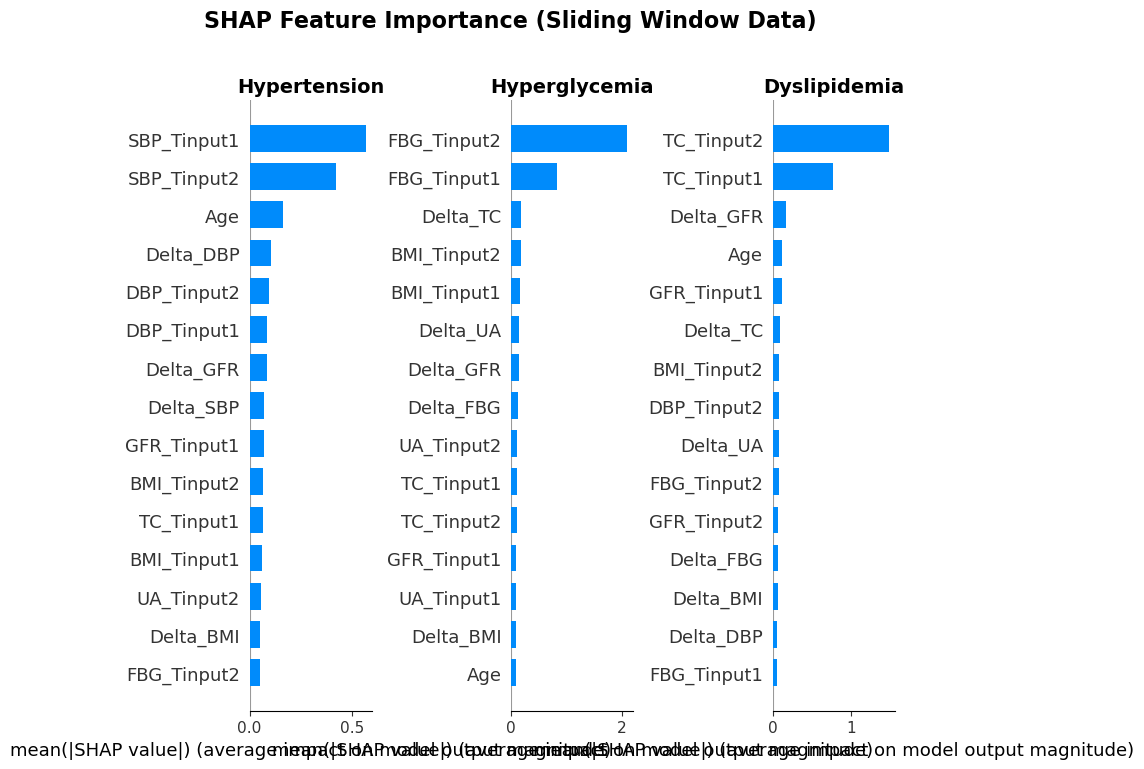

Saved: results/shap_sliding_window_importance.png


In [7]:
# Summary plots for each disease
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (disease, shap_values) in enumerate(shap_values_dict.items()):
    plt.sca(axes[idx])
    shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False, max_display=15)
    axes[idx].set_title(f'{disease}', fontsize=14, fontweight='bold')

plt.suptitle('SHAP Feature Importance (Sliding Window Data)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../results/shap_sliding_window_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/shap_sliding_window_importance.png")

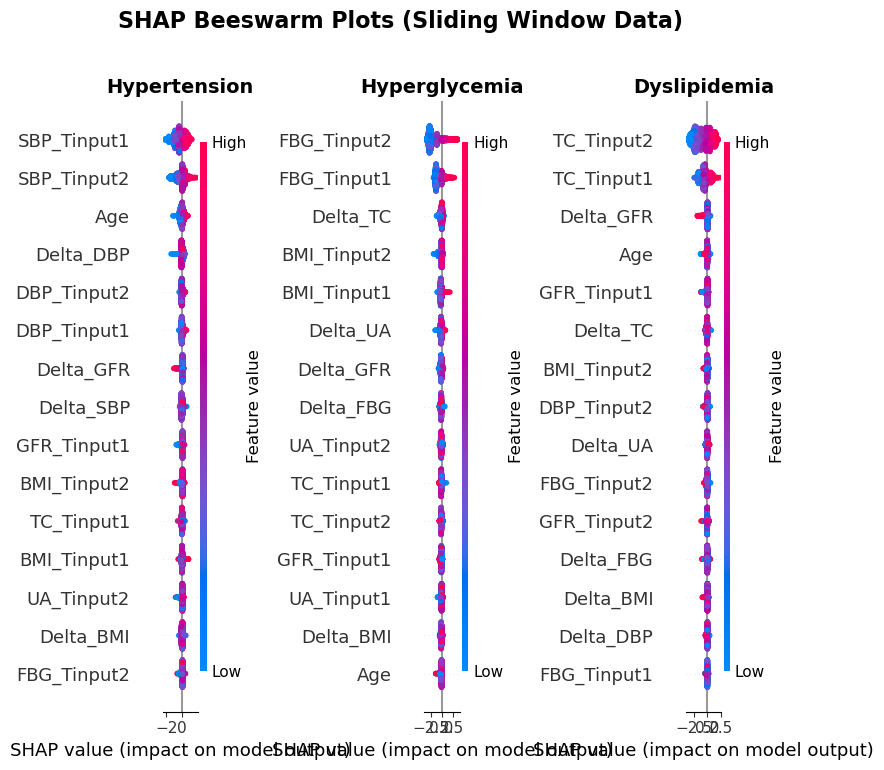

Saved: results/shap_sliding_window_beeswarm.png


In [8]:
# Beeswarm plots
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

for idx, (disease, shap_values) in enumerate(shap_values_dict.items()):
    plt.sca(axes[idx])
    shap.summary_plot(shap_values, X_test_df, show=False, max_display=15)
    axes[idx].set_title(f'{disease}', fontsize=14, fontweight='bold')

plt.suptitle('SHAP Beeswarm Plots (Sliding Window Data)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../results/shap_sliding_window_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/shap_sliding_window_beeswarm.png")

## 4. Feature Importance Comparison

In [9]:
# Calculate mean |SHAP| for each disease
importance_df = pd.DataFrame({'Feature': feature_cols})

for disease, shap_values in shap_values_dict.items():
    importance_df[disease] = np.abs(shap_values).mean(axis=0)

# Sort by Hypertension importance
importance_df = importance_df.sort_values('Hypertension', ascending=False)

print("="*80)
print("SHAP Feature Importance (Top 15)")
print("="*80)
print(importance_df.head(15).to_string(index=False))

SHAP Feature Importance (Top 15)
    Feature  Hypertension  Hyperglycemia  Dyslipidemia
SBP_Tinput1      0.567909       0.072020      0.036479
SBP_Tinput2      0.423229       0.057124      0.050803
        Age      0.164311       0.078177      0.113088
  Delta_DBP      0.103863       0.057885      0.058843
DBP_Tinput2      0.094734       0.060096      0.083282
DBP_Tinput1      0.087149       0.071184      0.054830
  Delta_GFR      0.086896       0.132986      0.168356
  Delta_SBP      0.072473       0.070714      0.046948
GFR_Tinput1      0.071919       0.090389      0.112577
BMI_Tinput2      0.066085       0.172809      0.084652
 TC_Tinput1      0.063403       0.097826      0.765531
BMI_Tinput1      0.063230       0.155641      0.053953
 UA_Tinput2      0.057319       0.102772      0.042942
  Delta_BMI      0.053187       0.087077      0.069031
FBG_Tinput2      0.051233       2.107033      0.072810


In [10]:
# Categorize features
def categorize_feature(name):
    if name in ['sex', 'Age']:
        return 'Demographics'
    elif 'Tinput1' in name:
        return 'Tinput1'
    elif 'Tinput2' in name:
        return 'Tinput2'
    elif 'Delta' in name:
        return 'Delta'
    return 'Other'

importance_df['Category'] = importance_df['Feature'].apply(categorize_feature)

# Aggregate by category
category_importance = importance_df.groupby('Category')[['Hypertension', 'Hyperglycemia', 'Dyslipidemia']].sum()

print("\n" + "="*60)
print("Feature Category Importance")
print("="*60)
print(category_importance)


Feature Category Importance
              Hypertension  Hyperglycemia  Dyslipidemia
Category                                               
Delta             0.431630       0.823589      0.611580
Demographics      0.168759       0.082612      0.157010
Tinput1           0.967221       1.428036      1.149075
Tinput2           0.775889       2.703867      1.937564


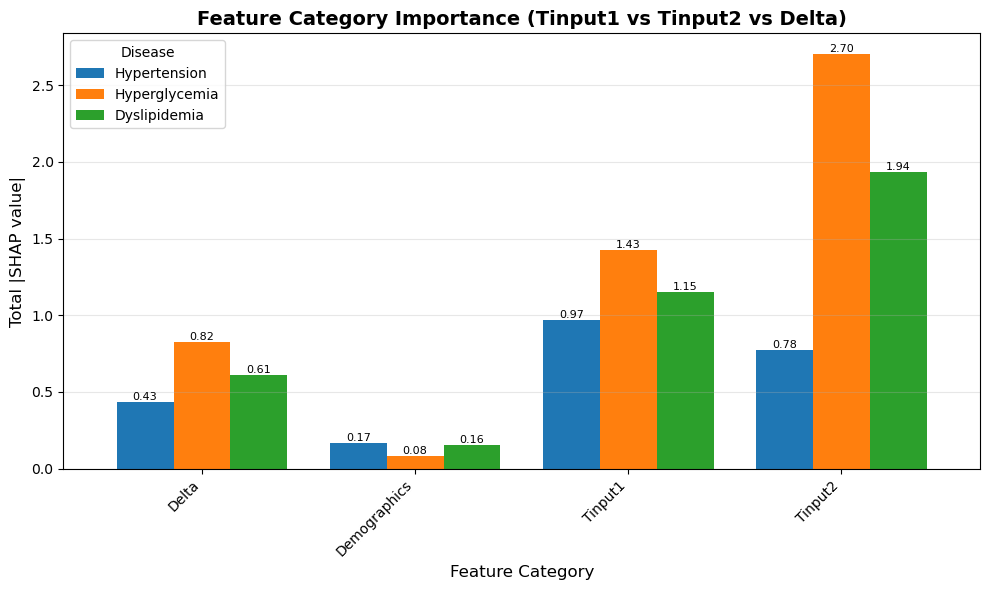

Saved: results/shap_sliding_window_category.png


In [11]:
# Visualize category importance
fig, ax = plt.subplots(figsize=(10, 6))

category_importance.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Feature Category', fontsize=12)
ax.set_ylabel('Total |SHAP value|', fontsize=12)
ax.set_title('Feature Category Importance (Tinput1 vs Tinput2 vs Delta)', fontsize=14, fontweight='bold')
ax.legend(title='Disease', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8)

plt.tight_layout()
plt.savefig('../../results/shap_sliding_window_category.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/shap_sliding_window_category.png")

In [12]:
# Save full results
importance_df.to_csv('../../results/shap_sliding_window_importance.csv', index=False)
print("Saved: results/shap_sliding_window_importance.csv")

# Summary
print("\n" + "="*80)
print("Summary")
print("="*80)
print(f"""
Data:
  - Samples: {len(df):,} (sliding window)
  - Patients: {df['patient_id'].nunique():,}
  - Features: {len(feature_cols)}

Top Features by Disease:
""")

for disease in ['Hypertension', 'Hyperglycemia', 'Dyslipidemia']:
    top3 = importance_df.nlargest(3, disease)[['Feature', disease]]
    print(f"  {disease}:")
    for _, row in top3.iterrows():
        print(f"    - {row['Feature']}: {row[disease]:.3f}")

Saved: results/shap_sliding_window_importance.csv

Summary

Data:
  - Samples: 13,514 (sliding window)
  - Patients: 6,056
  - Features: 26

Top Features by Disease:

  Hypertension:
    - SBP_Tinput1: 0.568
    - SBP_Tinput2: 0.423
    - Age: 0.164
  Hyperglycemia:
    - FBG_Tinput2: 2.107
    - FBG_Tinput1: 0.825
    - Delta_TC: 0.182
  Dyslipidemia:
    - TC_Tinput2: 1.490
    - TC_Tinput1: 0.766
    - Delta_GFR: 0.168


## 5. Conclusion

This notebook uses the sliding window dataset (13,514 samples) for SHAP analysis.

Key findings will be compared with the original 08_SHAP_Analysis results to verify consistency.